In [34]:
import pandas as pd
import numpy as np
import json
import os

In [35]:
from IPython.display import display, HTML

# For pandas dataframes - show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# For numpy arrays - show all elements
np.set_printoptions(threshold=np.inf)

# For pretty display of large HTML content
HTML("<style>.jp-OutputArea-output { max-height: none; }</style>")

In [26]:
folder_path = "./humaneval/python-small-test/"
json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]

all_entries = []

for file in json_files:
    file_path = os.path.join(folder_path, file)
    with open(file_path, "r") as f:
        content = json.load(f)
    for entry in content.get("data", []):
        entry["source_file"] = file
        all_entries.append(entry)

df = pd.DataFrame(all_entries)

# Step 2: Flatten `code_gpt_score` subfields
score_df = pd.json_normalize(df["code_gpt_score"])

# Step 3: Merge back to the original dataframe
df = df.drop(columns=["code_gpt_score"]).join(score_df)

# Optional: rename columns if needed
df = df.rename(columns={
    "code_gpt_score": "gpt_score",
    "comparison": "gpt_comparison",
    "parsed_comparison": "gpt_parsed_comparison"
})


df.head(2)


,pass,question,program,canonical_solution,question_id,source_file,gpt_score,gpt_comparison,gpt_parsed_comparison
0,True,"Task We are given two strings s and c, you hav...","def reverse_delete(s,c):\n\n # your code he...","def reverse_delete(s,c):\n s = ''.join([cha...",112,Qwen-2-0-4-0.4-sample-0.json,0.0,1. The problem statement requires a function t...,Yes
1,True,You're given a list of deposit and withdrawal ...,from typing import List\n\n\ndef below_zero(op...,from typing import List\n\n\ndef below_zero(op...,3,Qwen-2-0-4-0.4-sample-0.json,1.0,Let's evaluate the code snippet step by step t...,Yes


In [27]:
import re

def parse_filename(filename):
    """
    Parse a filename in the format 'Qwen-2-0-4-0.4-sample-0.json' to extract components.
    
    Args:
        filename (str): The filename to parse
        
    Returns:
        dict: Dictionary containing extracted components or None if pattern doesn't match
    """
    # Regular expression to match the pattern: Qwen-<step>-<analyze_prompt_index>-<compare_prompt_index>-<temperature>-sample-<number>.json
    pattern = r'Qwen-(\d+)-(\d+)-(\d+)-(\d+\.\d+)-sample-\d+\.json'
    
    match = re.match(pattern, filename)
    if match:
        return {
            'source_file': filename,
            'step': int(match.group(1)),
            'analyze_prompt_index': int(match.group(2)),
            'compare_prompt_index': int(match.group(3)),
            'temperature': float(match.group(4))
        }
    return None

def create_dataframe_from_filenames(file_list):
    """
    Create a DataFrame from a list of filenames by parsing each filename.
    
    Args:
        file_list (list): List of filenames to parse
        
    Returns:
        pandas.DataFrame: DataFrame containing the parsed information
    """
    results = []
    
    for filename in file_list:
        parsed_data = parse_filename(filename)
        if parsed_data:
            results.append(parsed_data)
    
    if not results:
        return pd.DataFrame(columns=['filename', 'step', 'analyze_prompt_index', 
                                    'compare_prompt_index', 'temperature'])
    
    return pd.DataFrame(results)

def process_directory(directory_path):
    """
    Process all matching files in a directory and return a DataFrame.
    
    Args:
        directory_path (str): Path to the directory containing the files
        
    Returns:
        pandas.DataFrame: DataFrame containing the parsed information
    """
    filenames = [f for f in os.listdir(directory_path) 
                if f.startswith('Qwen-') and f.endswith('.json')]
    return create_dataframe_from_filenames(filenames)

In [28]:
parsed_df = process_directory("./humaneval/python-small-test/")
df = pd.merge(
        df, 
        parsed_df, 
        on='source_file',
        how='inner'  # Only keep rows that match in both dataframes
    )

df.head(2)

,pass,question,program,canonical_solution,question_id,source_file,gpt_score,gpt_comparison,gpt_parsed_comparison,step,analyze_prompt_index,compare_prompt_index,temperature
0,True,"Task We are given two strings s and c, you hav...","def reverse_delete(s,c):\n\n # your code he...","def reverse_delete(s,c):\n s = ''.join([cha...",112,Qwen-2-0-4-0.4-sample-0.json,0.0,1. The problem statement requires a function t...,Yes,2,0,4,0.4
1,True,You're given a list of deposit and withdrawal ...,from typing import List\n\n\ndef below_zero(op...,from typing import List\n\n\ndef below_zero(op...,3,Qwen-2-0-4-0.4-sample-0.json,1.0,Let's evaluate the code snippet step by step t...,Yes,2,0,4,0.4


Metrics for each parameter combination:


,analyze_prompt_index,compare_prompt_index,temperature,accuracy,f1_score
2,0,2,0.4,0.863636,0.857143
6,0,8,0.4,0.863636,0.863636
8,1,0,0.4,0.863636,0.863636
5,0,4,0.9,0.856061,0.859259
12,1,4,0.4,0.856061,0.857143
14,1,8,0.4,0.856061,0.857143
3,0,2,0.9,0.856061,0.850394
4,0,4,0.4,0.848485,0.843750
10,1,2,0.4,0.848485,0.838710
9,1,0,0.9,0.848485,0.848485



Overall Metrics:
Accuracy: 0.8433
F1 Score: 0.8406


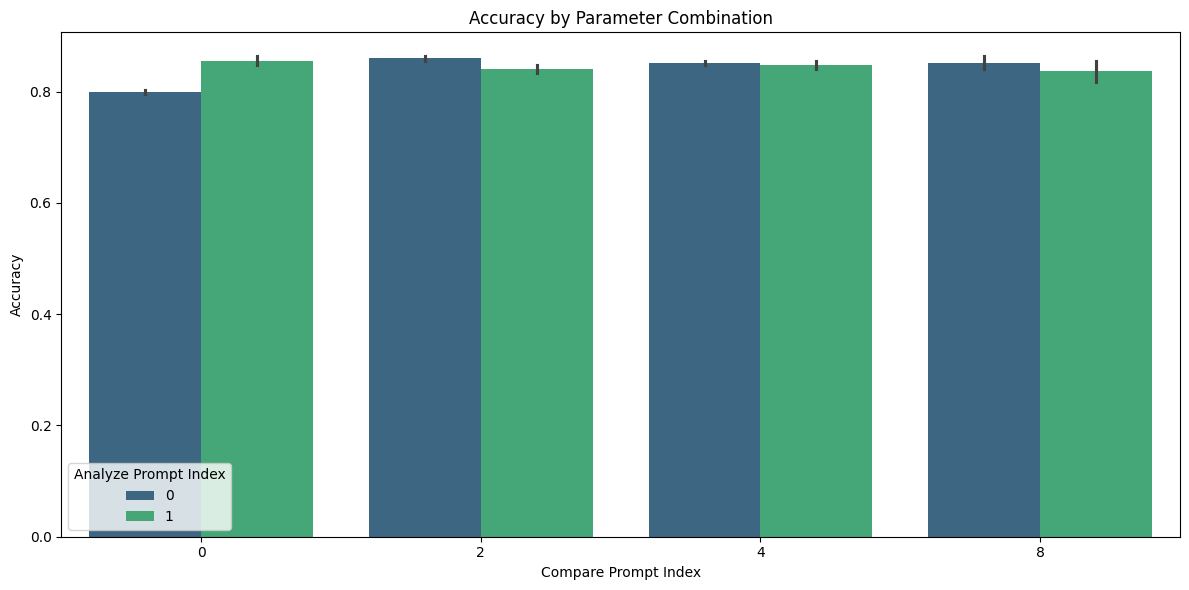

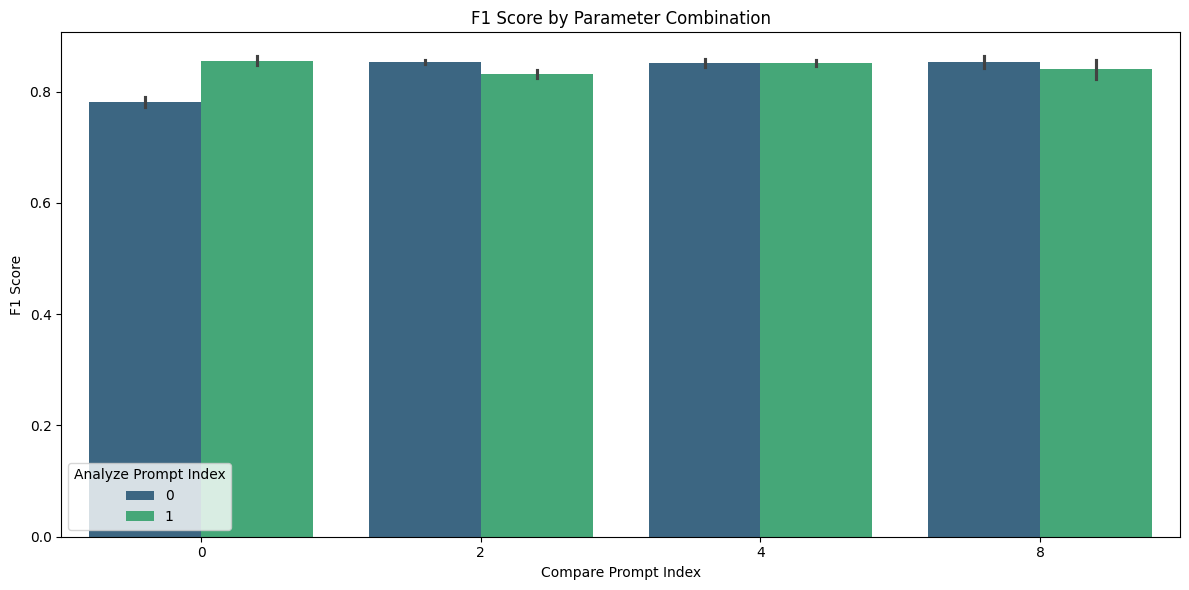

In [37]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert string 'Yes'/'No' to boolean True/False to match with 'pass'
df['predicted_bool'] = df['gpt_parsed_comparison'].apply(lambda x: True if x == 'Yes' else False)

# Group by the parameters we're interested in
grouped = df.groupby(['analyze_prompt_index', 'compare_prompt_index', 'temperature'])

# Create a dataframe to store the results
results = []

# Calculate metrics for each group
for name, group in grouped:
    analyze_idx, compare_idx, temp = name
    group_accuracy = accuracy_score(group['pass'], group['predicted_bool'])
    group_f1 = f1_score(group['pass'], group['predicted_bool'])
    group_conf_matrix = confusion_matrix(group['pass'], group['predicted_bool'])
    
    # Store the results
    results.append({
        'analyze_prompt_index': analyze_idx,
        'compare_prompt_index': compare_idx,
        'temperature': temp,
        'accuracy': group_accuracy,
        'f1_score': group_f1,
        'sample_size': len(group),
        'TN': group_conf_matrix[0, 0] if group_conf_matrix.shape == (2, 2) else 0,
        'FP': group_conf_matrix[0, 1] if group_conf_matrix.shape == (2, 2) else 0,
        'FN': group_conf_matrix[1, 0] if group_conf_matrix.shape == (2, 2) else 0,
        'TP': group_conf_matrix[1, 1] if group_conf_matrix.shape == (2, 2) else 0
    })

# Convert to DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Sort by accuracy (descending)
results_df = results_df.sort_values('accuracy', ascending=False)

# Display the results
print("Metrics for each parameter combination:")
display(results_df[['analyze_prompt_index', 'compare_prompt_index', 'temperature', 'accuracy', 'f1_score']])

# Calculate overall metrics for comparison
overall_accuracy = accuracy_score(df['pass'], df['predicted_bool'])
overall_f1 = f1_score(df['pass'], df['predicted_bool'])
print(f"\nOverall Metrics:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"F1 Score: {overall_f1:.4f}")

# Visualize accuracy by parameter combination
plt.figure(figsize=(12, 6))
sns.barplot(x='compare_prompt_index', y='accuracy', hue='analyze_prompt_index',
            palette='viridis', data=results_df)
plt.title('Accuracy by Parameter Combination')
plt.xlabel('Compare Prompt Index')
plt.ylabel('Accuracy')
plt.legend(title='Analyze Prompt Index')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Visualize F1 score by parameter combination
plt.figure(figsize=(12, 6))
sns.barplot(x='compare_prompt_index', y='f1_score', hue='analyze_prompt_index',
            palette='viridis', data=results_df)
plt.title('F1 Score by Parameter Combination')
plt.xlabel('Compare Prompt Index')
plt.ylabel('F1 Score')
plt.legend(title='Analyze Prompt Index')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [38]:
df[(df['gpt_parsed_comparison'] != 'Yes') & (df['gpt_parsed_comparison'] != 'No')]

pass  \
75     True   
102    True   
132    True   
133    True   
134    True   
135   False   
137   False   
138    True   
139   False   
140    True   
141    True   
142    True   
143   False   
144   False   
145   False   
146   False   
147   False   
148   False   
149    True   
150    True   
151    True   
152   False   
153    True   
154    True   
155   False   
156    True   
876    True   
1092   True   
1396   True   
1559  False   
1669   True   
1789   True   
1840  False   
1871  False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   question  \
75                                                                                                                                                                                                                                                                                    The Fib4 number sequence is a sequence similar to the Fibbonacci sequnece that's defined as follows: fib4(0) -> 0 fib4(1) -> 0 fib4(2) -> 2 fib4(3) -> 0 fib4(n) -> fib4(n-1) + fib4(n-2) + fib4(n-3) + fib4(n-4). Please write a function to efficiently compute the n-th element of the fib4 number sequence. Do not use recursion.   
102                                                                                                                                            You are given a 2 dimensional data, as a nested lists, which is similar to matrix, however, unlike matrices, each row may contain a different number of columns. Given lst, and integer x, find integers x in the list, and return list of tuples, [(x1, y1), (x2, y2) ...] such that each tuple is a coordinate - (row, columns), starting with 0. Sort coordinates initially by rows in ascending order. Also, sort coordinates of the row by columns in descending order.   
132                                                                                                                                                                                                                                                                                     Task We are given two strings s and c, you have to deleted all the characters in s that are equal to any character in c then check if the result string is palindrome. A string is called palindrome if it reads the same backward as forward. You should return a tuple containing the result string and True/False for the check.   
133                                                                                                                                                                                                                                                                                                                                             You're given a list of deposit and withdrawal operations on a bank account that starts with zero balance. Your task is to detect if at any point the balance of account fallls below zero, and at that point function should return True. Otherwise it should return False.   
134                                                                                                                                                                                                                                                                                                                                                                                                                      This function takes two positive numb